In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
import sys
sys.path.insert(0,'../')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+dc10b30 torch: 0.3.0.post4 cuda: False


In [2]:
from functools import wraps

# TODO: move this into probtorch.util
def expand_inputs(f):
    @wraps(f)
    def g(*args, num_samples=None, **kwargs):
        if not num_samples is None:
            new_args = []
            new_kwargs = {}
            for arg in args:
                if hasattr(arg, 'expand'):
                    new_args.append(arg.expand(num_samples, *arg.size()))
                else:
                    new_args.append(arg)
            for k in kwargs:
                arg = kwargs[k]
                if hasattr(arg, 'expand'):
                    new_args.append(arg.expand(num_samples, *arg.size()))
                else:
                    new_args.append(arg)
            return f(*new_args, num_samples=num_samples, **new_kwargs)
        else:
            return f(*args, num_samples=None, **kwargs)
    return g

# Parameters

In [3]:
# Model Paramters:
NUM_PIXELS = 784
NUM_HIDDEN1 = 400
NUM_HIDDEN2 = 200
NUM_STYLE = 10 
NUM_DIGITS = 10

# Training Parameters:
NUM_SAMPLES = 1
NUM_BATCH = 500
NUM_EPOCHS = 200
LABEL_FRACTION = 0.1
LEARNING_RATE = 1e-3
EPS = 1e-9
CUDA = torch.cuda.is_available()

# LOSS parameters:
ALPHA = 0.1
BETA = (4.0, 1.0, 0.0, 1.0) 

# Encoder Model

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, num_pixels=NUM_PIXELS,
                       num_hidden1=NUM_HIDDEN1,
                       num_hidden2=NUM_HIDDEN2,
                       num_style=NUM_STYLE,
                       num_digits=NUM_DIGITS):
        
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
                            nn.Linear(num_pixels, num_hidden1),
                            nn.ReLU())
        self.digit_log_weights = nn.Linear(num_hidden1, num_digits)
        self.digit_temp = 0.66
        self.style_mean = nn.Sequential(
                            nn.Linear(num_hidden1 + num_digits, num_hidden2),
                            nn.ReLU(),
                            nn.Linear(num_hidden2, num_style))
        self.style_log_std = nn.Sequential(
                                nn.Linear(num_hidden1 + num_digits, num_hidden2),
                                nn.ReLU(),
                                nn.Linear(num_hidden2, num_style))

    @expand_inputs
    def forward(self, images, labels=None, num_samples=None):
        q = probtorch.Trace()
        hidden = self.enc_hidden(images)
        # input digits : unkown or observed
        digits = q.concrete(self.digit_log_weights(hidden), self.digit_temp, value=labels, name='y')        
        # input features : unkown
        hidden2 = torch.cat([digits, hidden] , -1)
        styles_mean = self.style_mean(hidden2)
        styles_std = torch.exp(self.style_log_std(hidden2))
        q.normal(styles_mean, styles_std, name='z')
        return q 

# Decoder Model

In [5]:
def binary_cross_entropy(x_mean, x, EPS=1e-9):
    return - (torch.log(x_mean + EPS) * x + 
              torch.log(1 - x_mean + EPS) * (1 - x)).sum(-1)

class Decoder(nn.Module):
    
    def __init__(self, num_pixels=NUM_PIXELS,
                       num_hidden1=NUM_HIDDEN1,
                       num_hidden2=NUM_HIDDEN2,
                       num_style=NUM_STYLE,
                       num_digits=NUM_DIGITS):
        
        super(self.__class__, self).__init__()
        self.dec_hidden = nn.Sequential(
                            nn.Linear(num_style + num_digits, num_hidden2),
                            nn.ReLU(),
                            nn.Linear(num_hidden2, num_hidden1),
                            nn.ReLU())
        
        # prior for digit (y)
        self.digit_log_weights = Parameter(torch.zeros(num_digits))
        self.digit_temp = 0.66
        
        # prior for features (z)
        self.style_mean = Parameter(torch.zeros(num_style))
        self.style_log_std = Parameter(torch.zeros(num_style))
        
        self.dec_images = nn.Sequential(
                            nn.Linear(num_hidden1, num_pixels),
                            nn.Sigmoid())
        
        
    def forward(self, images, q=None, num_samples=None):
        p = probtorch.Trace()
        
        # sample digits : unkown or observed
        digits = digits = p.concrete(self.digit_log_weights, self.digit_temp,
                            value=q['y'],
                            name='y')
        
        # sample features : unkown
        styles = p.normal(0.0, 1.0,
                          value=q['z'],
                          name='z')
        
        hiddens = self.dec_hidden(torch.cat([digits, styles], -1))
        images_mean = self.dec_images(hiddens)
        p.loss(binary_cross_entropy, images_mean, images, name='images')
        
        return p

# Loss

In [6]:
def elbo(q, p, alpha=ALPHA, beta=BETA):
    return probtorch.objectives.marginal.elbo(q, p, sample_dim=0, batch_dim=1,
                                              alpha=alpha, beta=beta)

# Data

In [7]:
from torchvision import datasets, transforms
import os 
DATA_PATH = '../data'

if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)

train_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=True, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 
test_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=False, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 

# Training and Testing

In [8]:
enc = Encoder()
dec = Decoder()
if CUDA:
    enc.cuda()
    dec.cuda()
optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                              lr=LEARNING_RATE)


In [13]:
def train(data, enc, dec, optimizer, 
          label_mask={}, label_fraction=LABEL_FRACTION):
    epoch_elbo = 0.0
    enc.train()
    dec.train()
    N = 0
    for b, (images, labels) in enumerate(data):
        
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            labels_onehot = torch.zeros(NUM_BATCH, NUM_DIGITS)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
            labels_onehot = torch.clamp(labels_onehot, EPS, 1-EPS)
            if CUDA:
                images = images.cuda()
                labels_onehot = labels_onehot.cuda()
            images = Variable(images)
            labels_onehot = Variable(labels_onehot)
            optimizer.zero_grad()
            if b not in label_mask:
                label_mask[b] = (random() < label_fraction)
            if label_mask[b]:
                q = enc(images, labels_onehot, num_samples=NUM_SAMPLES)
            else:
                q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            loss = -elbo(q, p)
            loss.backward()
            optimizer.step()
            if CUDA:
                loss = loss.cpu()
            epoch_elbo -= loss.data.numpy()[0]
    return epoch_elbo / N, label_mask


def test(data, enc, dec, infer=True):
    enc.eval()
    dec.eval()
    epoch_elbo = 0.0
    epoch_correct = 0
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            images = Variable(images)
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            batch_elbo = elbo(q, p)
            if CUDA:
                batch_elbo = batch_elbo.cpu()
            epoch_elbo += batch_elbo.data.numpy()[0]
            
            log_p = p.log_joint(0, 1)
            log_q = q.log_joint(0, 1)
            log_w = log_p - log_q
            w = torch.nn.functional.softmax(log_w, 0)
            y_samples = q['y'].value
            y_expect = (w.unsqueeze(-1) * y_samples).sum(0)
            _ , y_pred = y_expect.data.max(-1)
            if CUDA:
                    y_pred = y_pred.cpu()
            epoch_correct += (labels == y_pred).sum()

    return epoch_elbo / N, epoch_correct / N


### Track every term in ELBO separately

In [14]:
from probtorch.objectives.montecarlo import log_like
from probtorch.distributions import Concrete
from numbers import Number
from torch.nn.functional import softmax

def elbo_track(q, p, sample_dim, batch_dim):
    y = q.conditioned()
    log_weights = q.log_joint(sample_dim, batch_dim, y)
    z_continuous = [n for n in q.sampled() if n in p and not isinstance(q[n].dist, Concrete)]
    log_avg_qz, log_avg_qzd_prod = q.log_pair(sample_dim, batch_dim, z_continuous)
    log_pz = p.log_joint(sample_dim, batch_dim, z_continuous)
    log_qz = q.log_joint(sample_dim, batch_dim, z_continuous)
    total_correlation = log_avg_qz - log_avg_qzd_prod
    prior_ratio =  log_avg_qzd_prod - log_pz
    mutual_info = log_qz - log_avg_qz
    
    log_qy = log_weights
    log_py = p.log_joint(sample_dim, batch_dim, y)
    z_concrete = [n for n in q.sampled() if n in p and isinstance(q[n].dist, Concrete)]
    log_pz = p.log_joint(sample_dim, batch_dim, z_concrete)
    log_qz = q.log_joint(sample_dim, batch_dim, z_concrete)
    log_ratio = (log_qy + log_qz - log_py - log_pz)
    
    if isinstance(log_weights, Number):
        total_correlation = total_correlation.mean(0)
        prior_ratio = prior_ratio.mean(0)
        mutual_info = mutual_info.mean(0)
        log_ratio = log_ratio.mean(0)
    else:
        weights = softmax(log_weights, 0)
        total_correlation = (weights * total_correlation).sum(0)
        prior_ratio = (weights * prior_ratio).sum(0)
        mutual_info = (weights * mutual_info).sum(0)
        log_ratio = (weights * log_ratio).sum(0)
    
    total_correlation = total_correlation.mean() 
    prior_ratio = prior_ratio.mean()
    mutual_info = mutual_info.mean()
    log_ratio = log_ratio.mean() 
    
    recun_loss = log_like(q, p, sample_dim, batch_dim, log_weights=None, size_average=True, reduce=True)
    
    return total_correlation.cpu().data.numpy(), prior_ratio.cpu().data.numpy(), \
            mutual_info.cpu().data.numpy(), recun_loss.cpu().data.numpy(), log_ratio.cpu().data.numpy()


In [ ]:
import time
from random import random

train_elbo_dict = {'ELBO':[], 'Recun Loss': [], 'TC': [], 'PriorZ':[], 'PriorY':[], 'MI':[]}
test_elbo_dict = {'ELBO':[], 'Recun Loss': [], 'TC': [], 'PriorZ':[], 'PriorY':[], 'MI':[]}
test_acc_list = []
mask = {}
for e in range(NUM_EPOCHS):
    train_start = time.time()
    train_elbo, mask = train(train_data, enc, dec, 
                             optimizer, mask, LABEL_FRACTION)
    train_end = time.time()
    test_start = time.time()
    test_elbo, test_accuracy = test(test_data, enc, dec)
    test_end = time.time()
    
    test_acc_list.append(test_accuracy)
    print('[Epoch %d] Train: ELBO %.4e (%ds) Test: ELBO %.4e, Accuracy %0.3f (%ds)' % (
            e, train_elbo, train_end - train_start, 
            test_elbo, test_accuracy, test_end - test_start))

[Epoch 0] Train: ELBO -3.7502e-01 (39s) Test: ELBO -3.4426e-01, Accuracy 0.194 (2s)


# Visualize Encodings

In [15]:
# Get all the embeddings
Zs = np.zeros((len(train_data),NUM_BATCH, NUM_STYLE))
for b, (images, labels) in enumerate(train_data):
        if images.size()[0] == NUM_BATCH:
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            images = Variable(images)
            q = enc(images, num_samples=NUM_SAMPLES)
            z = q['z'].value.cpu().data.squeeze().numpy()
            Zs[b] = z
Zs = Zs.reshape(-1,NUM_STYLE)

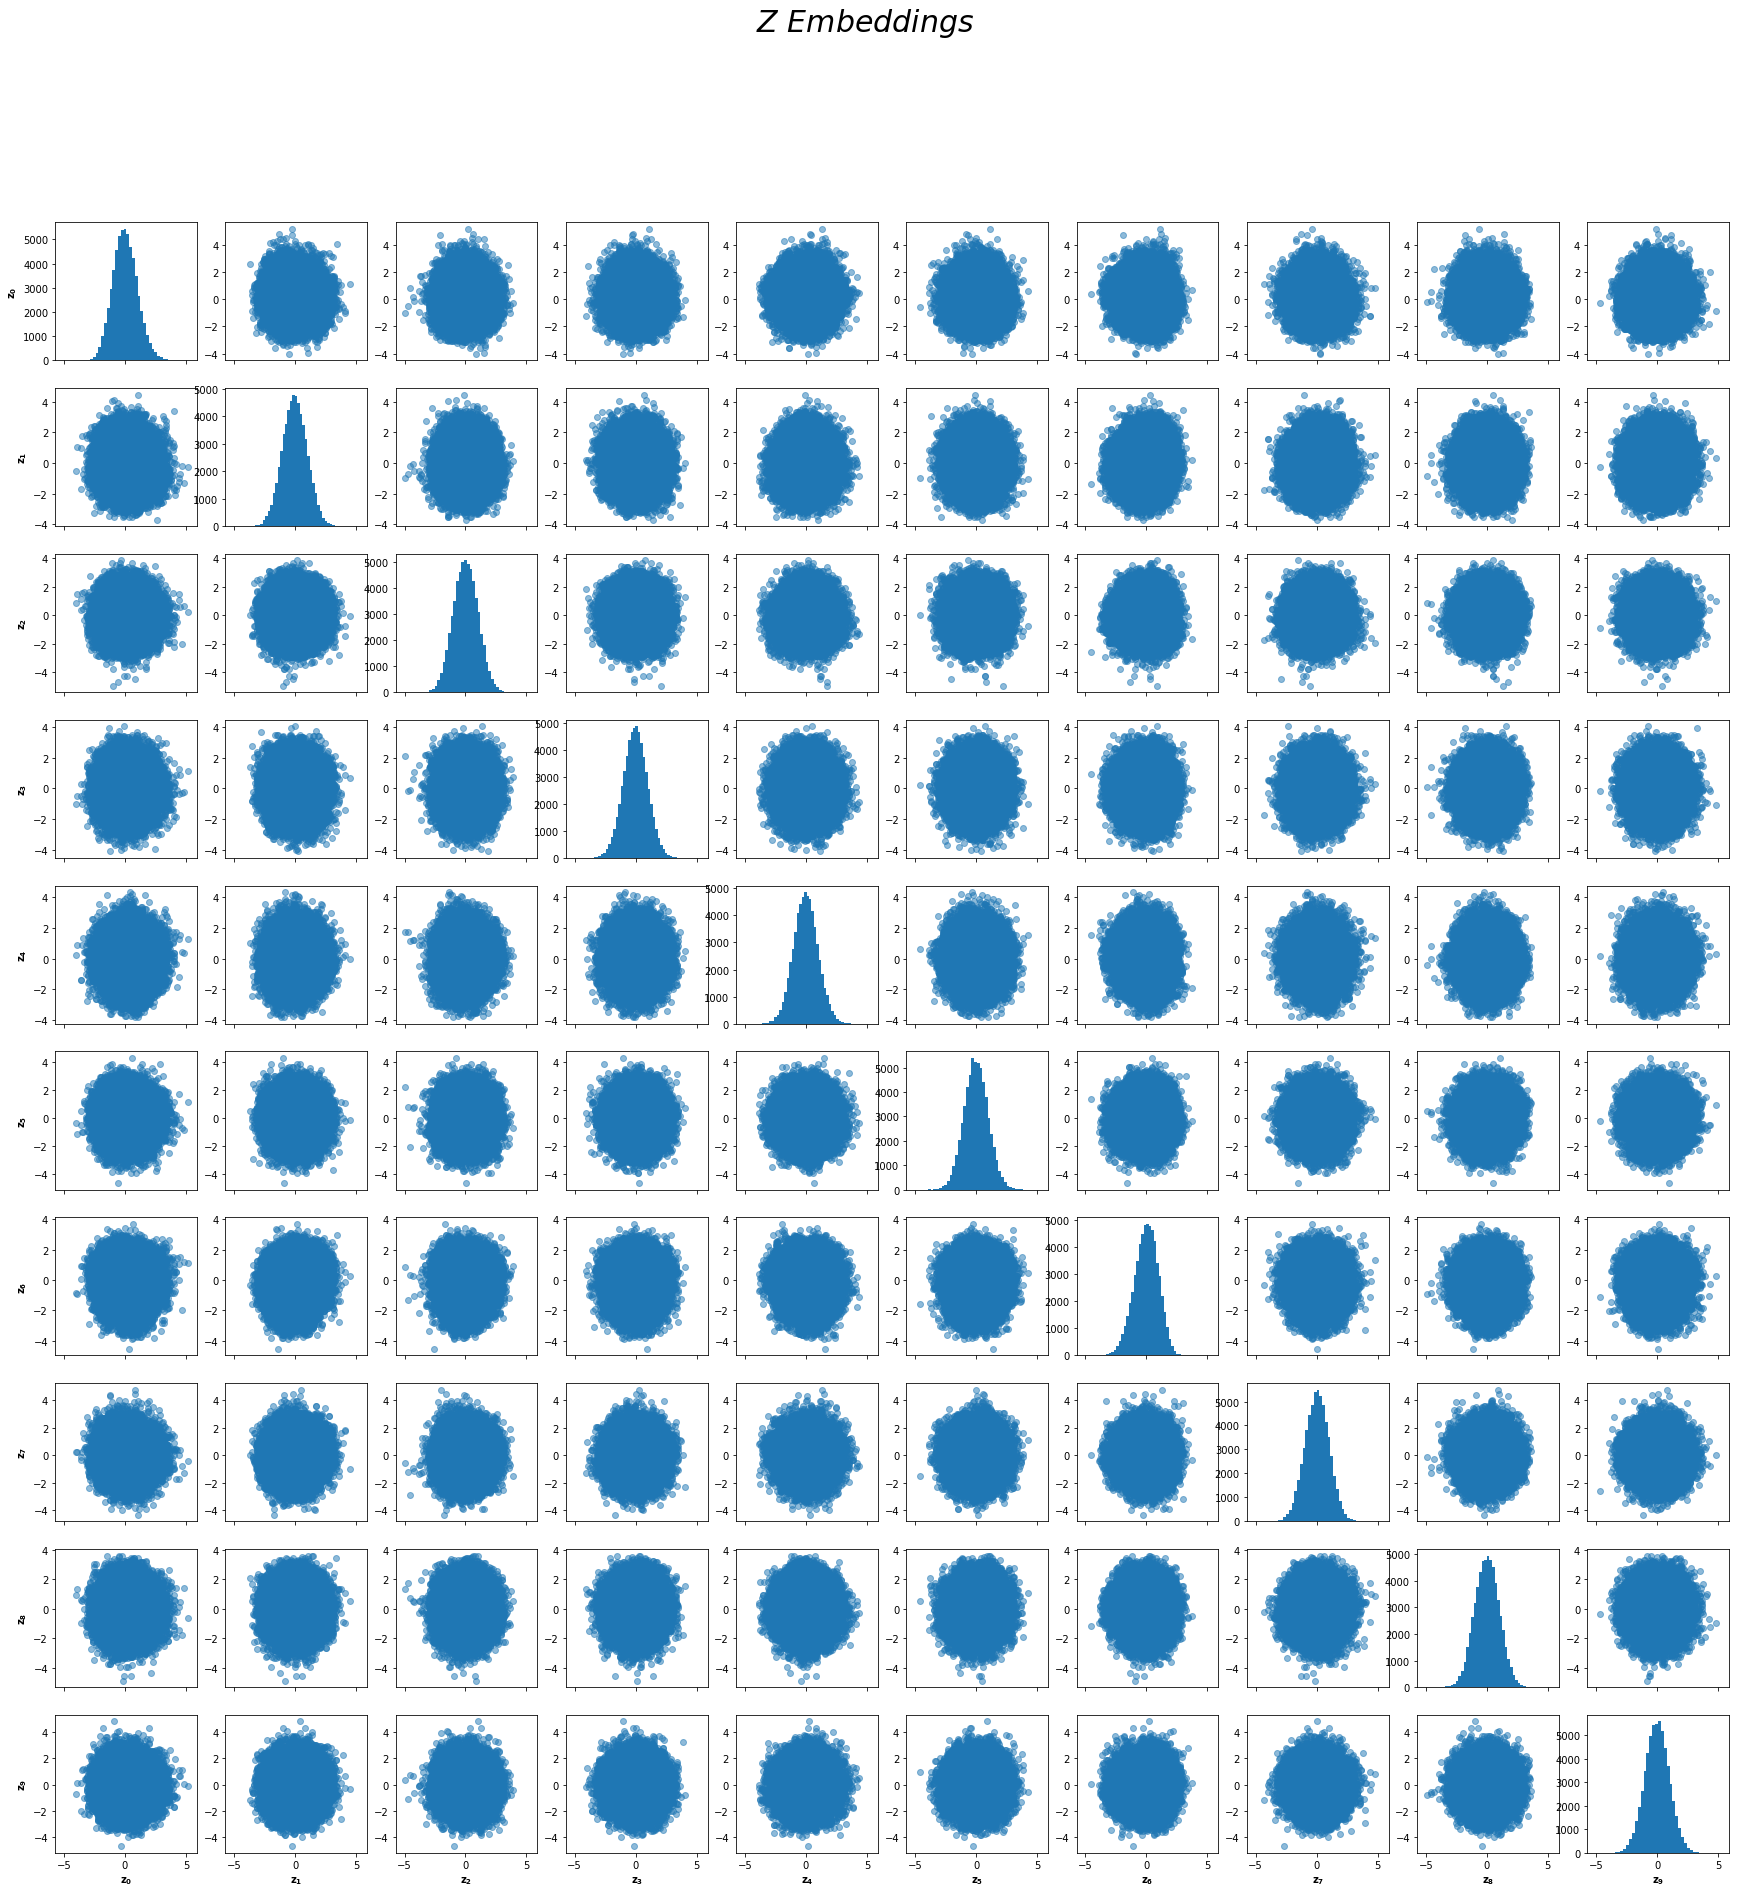

In [16]:
f, axarr = plt.subplots(NUM_STYLE, NUM_STYLE, figsize=(30, 30), sharex=True)
f.suptitle(r'$Z \ Embeddings$' , fontsize=30)

for i in range(NUM_STYLE):
    axarr[NUM_STYLE-1,i].set_xlabel(r'$\mathbf{z_{%d}}$' % i, fontsize=10)
    axarr[i,0].set_ylabel(r'$\mathbf{z_{%d}}$' % i, fontsize=10)
    for j in range(NUM_STYLE):
        if i==j:
            axarr[j,i].hist(Zs[:,i], bins=40)
        else:
            axarr[j,i].scatter(Zs[:,i],Zs[:,j],alpha=0.5)
            
plt.show()

# Let's see some Features!

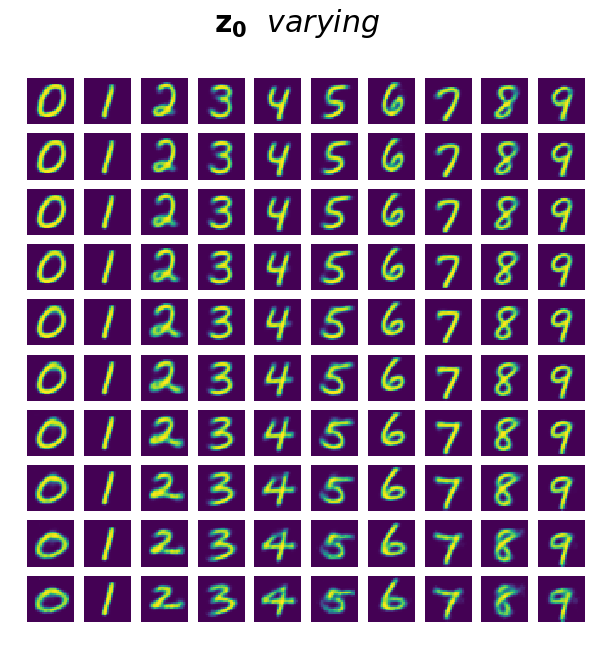

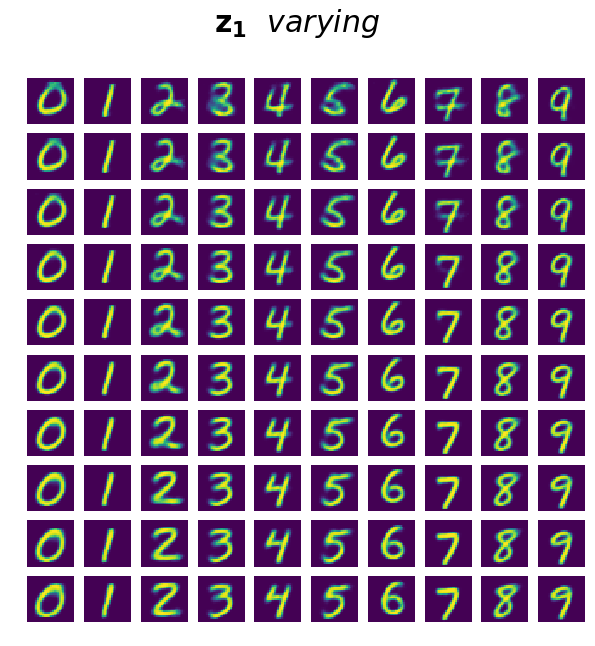

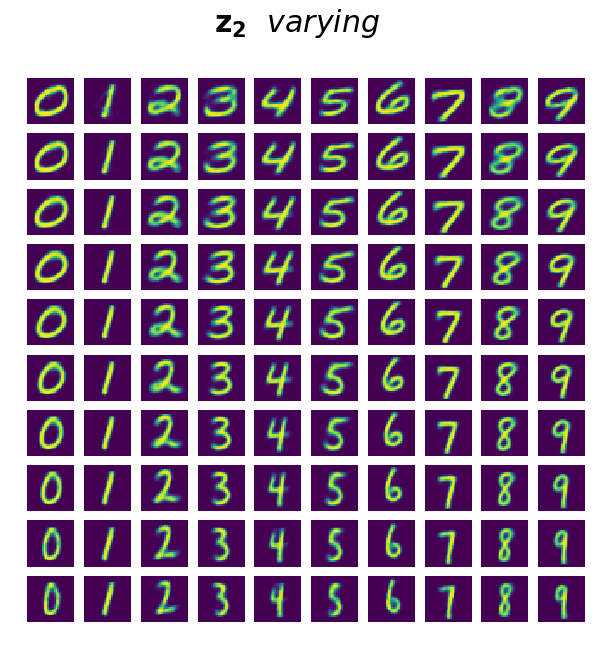

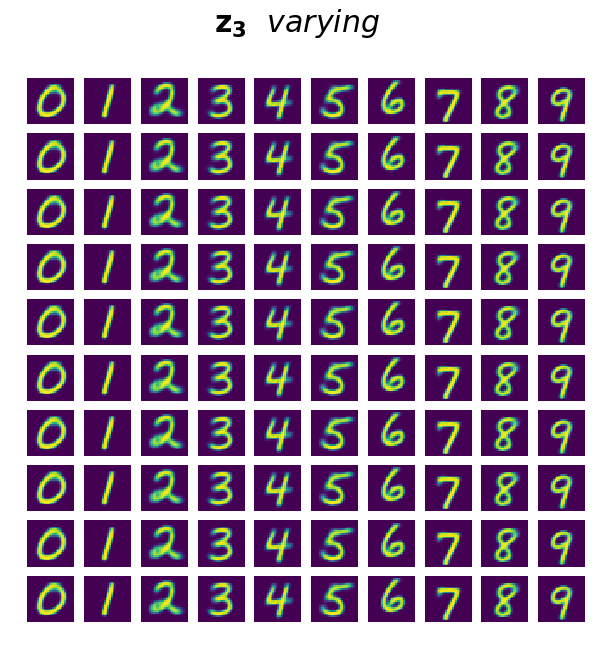

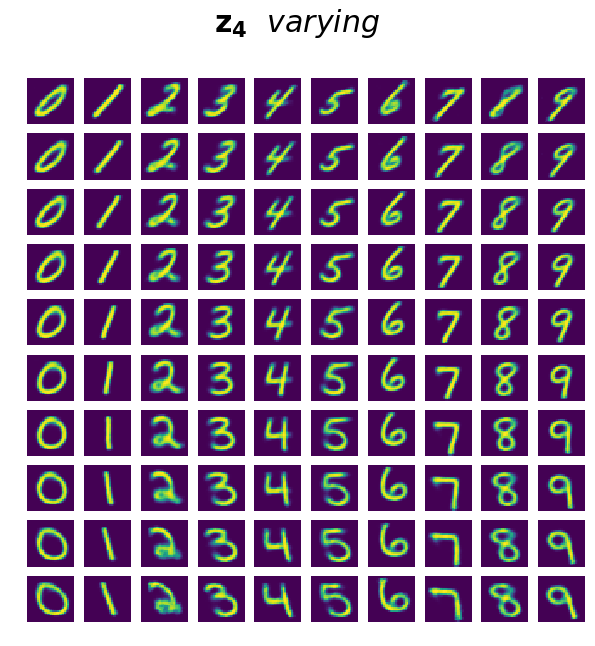

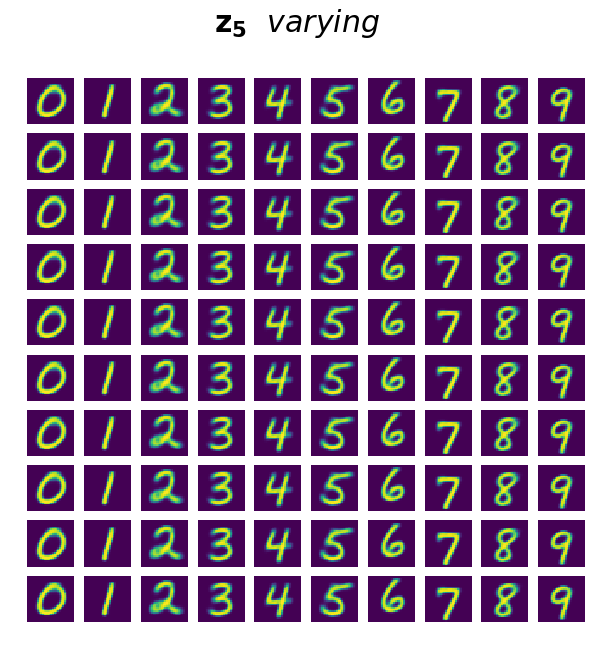

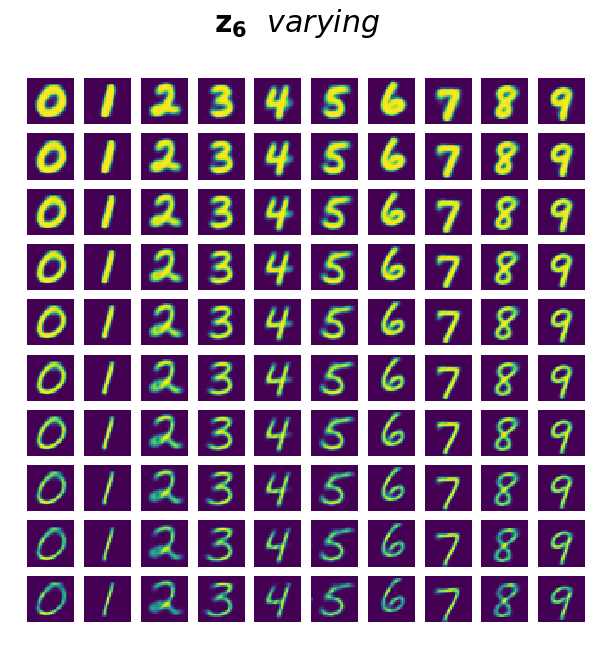

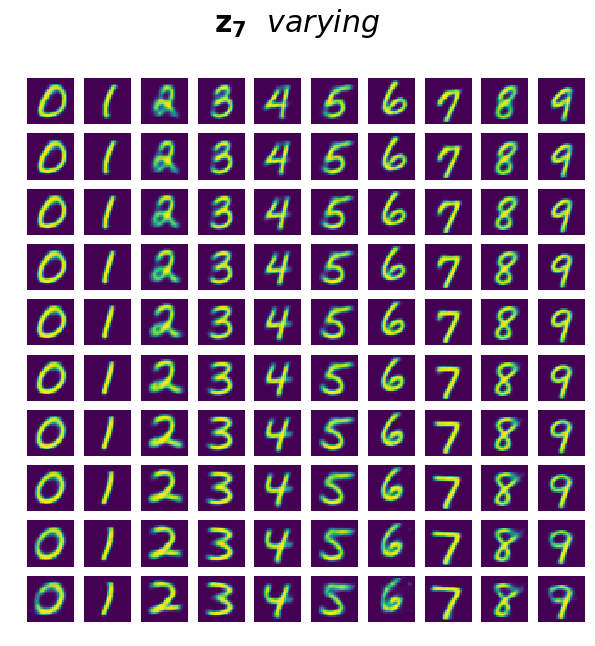

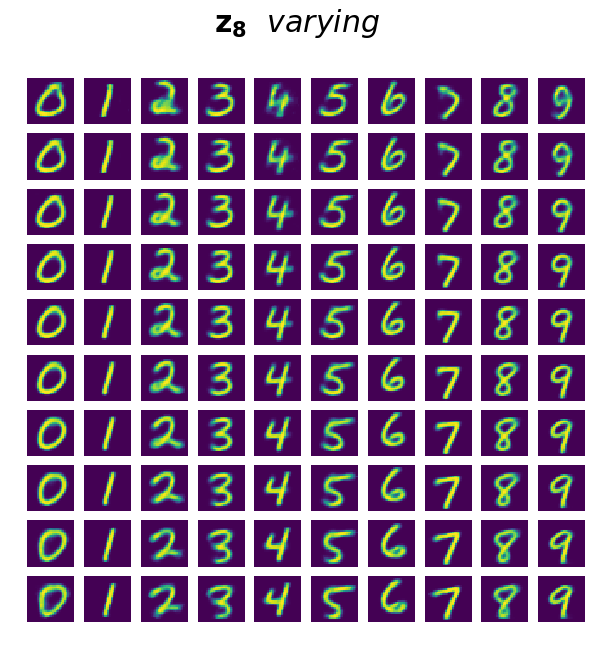

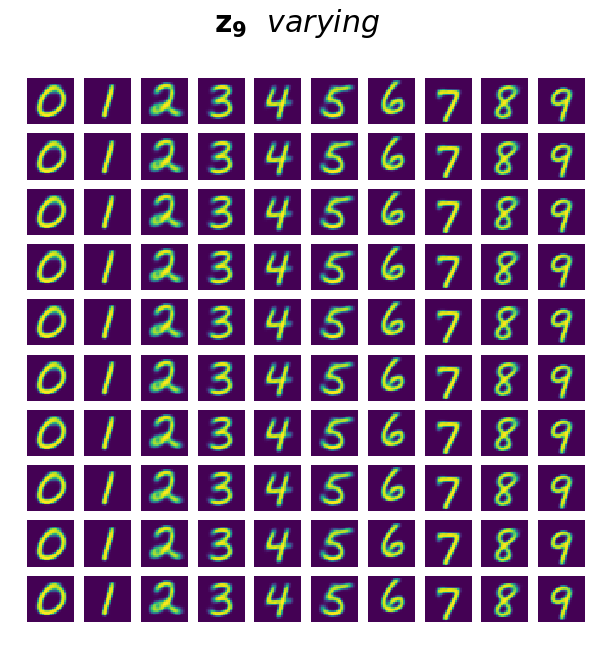

In [12]:
def vary_z2(index, zmin, zmax):
    f, axarr = plt.subplots(10,10,figsize=(10,10),sharey=True)
    f.suptitle(r'$\mathbf{z_{%d}} \ \  varying$' % index , fontsize=30)
    z_range = np.linspace(zmin,zmax,num=10)
    
    for i in range(10):
        for j in range(10):
            z = torch.zeros(1,10)
            z[0,index] = z_range[i]
            z = Variable(z.cuda())
            null_image = Variable(torch.Tensor(np.zeros((1, 784)))).cuda()
            y_hot = np.zeros((1,10))
            y_hot[0,j] = 1
            y_hot = Variable(torch.FloatTensor(y_hot).cuda())
            q_null = {'z': z, 'y':y_hot}
            p = dec(null_image, q_null, num_samples=NUM_SAMPLES) 
            image = p['images']
            image = image.value.cpu().data.numpy().reshape(28,28)
            axarr[i,j].imshow(image)
            axarr[i,j].axis('off')
            
    return None

for style in range(NUM_STYLE):
    vary_z2(style, -3, 3)
    plt.show()

1. feature 0: Horizontal angles (look at 3 ,4, and 7)
2. feature 1: Y-position of the middle line (look at 4 middle line)
3. feature 2: Width
4. feature 3: Nothing
5. feature 4: Angle 
6. feature 5: Nothing
7. feature 6: Stroke
8. feature 7: Not sure
9. feature 8: Top circle gets bigger, the other one smaller
10. feature 9: Nothing

## Features $z_{i}$ vs $z_{j}$ for Digits:

In [17]:
def zi_vs_zj(z_index1, z_index2, zmin=3, zmax=3, num_z=10, digit=0):
    f, axarr = plt.subplots(num_z, num_z, figsize=(num_z, num_z), sharey=True)
    f.suptitle(r'$Digit: %s$' % digit , fontsize=30)
    z_range = np.linspace(zmin,zmax,num=num_z)
    
    for i in range(num_z):
        for j in range(num_z):
            z = torch.zeros(1,NUM_STYLE)
            z[0,z_index1] = z_range[i]
            z[0,z_index2] = z_range[j]
            z = Variable(z.cuda())
            y_hot = np.zeros((1,NUM_DIGITS))
            y_hot[0,digit] = 1
            y_hot = Variable(torch.FloatTensor(y_hot).cuda())
            q_null = {'z':z, 'y':y_hot}
            null_image = Variable(torch.Tensor(np.zeros((1, NUM_PIXELS)))).cuda()
            p = dec(null_image, q_null, num_samples=NUM_SAMPLES) 
            image = p['images']
            pixels = int(np.sqrt(NUM_PIXELS))
            image = image.value.cpu().data.numpy().reshape(pixels,pixels)
            axarr[i,j].imshow(image)
            axarr[i,j].axis('off')
    f.text(0.52, 0.08, r'$\mathbf{z_{%d}}$' % z_index2, ha='center', fontsize=20)
    f.text(0.09, 0.5, r'$\mathbf{z_{%d}}$' % z_index1, va='center', rotation='vertical', fontsize=20)

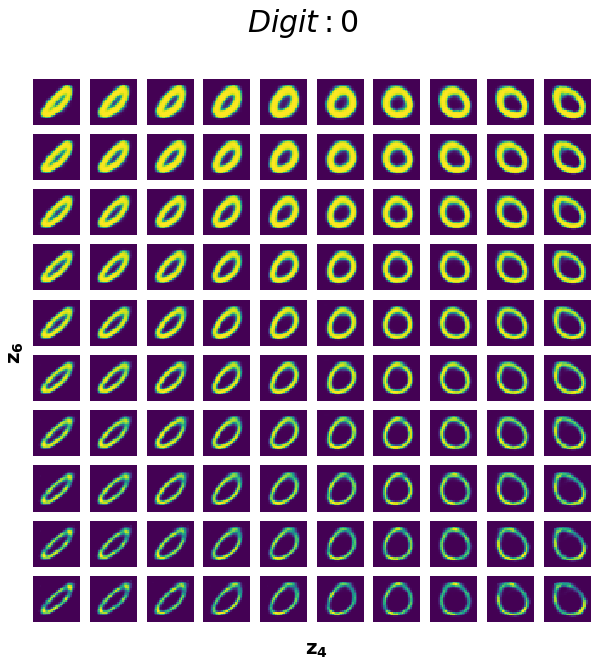

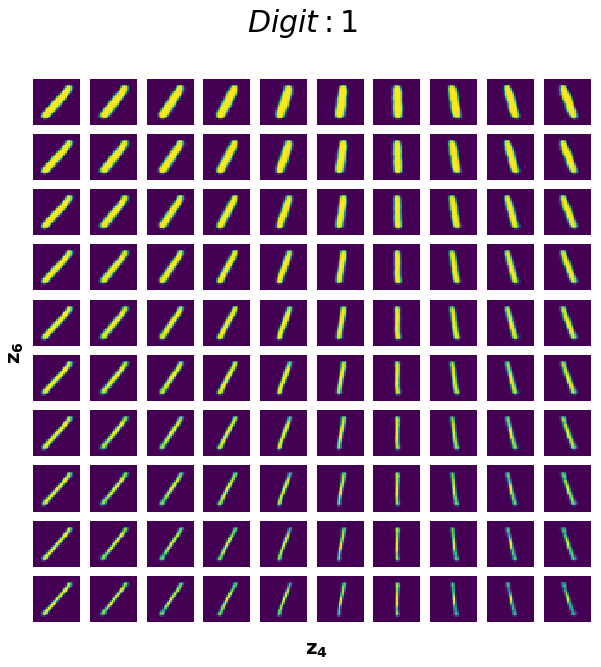

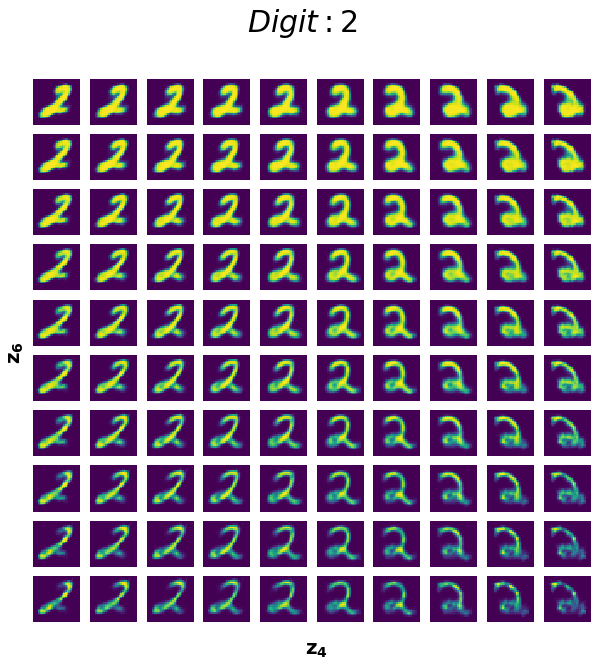

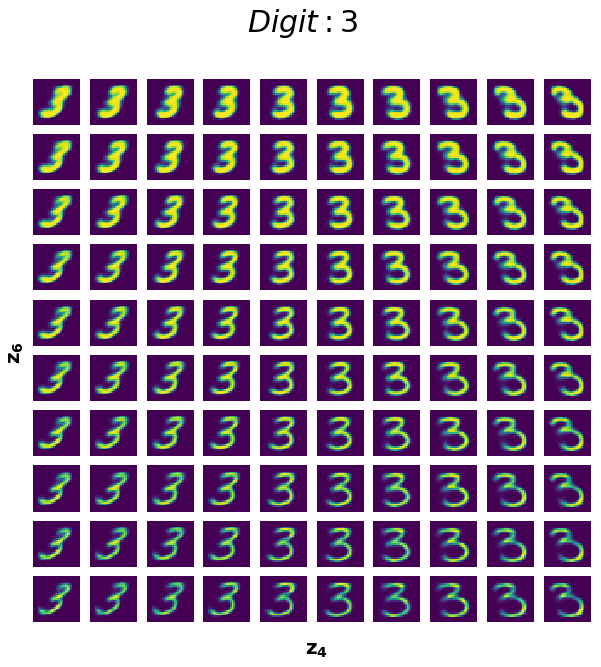

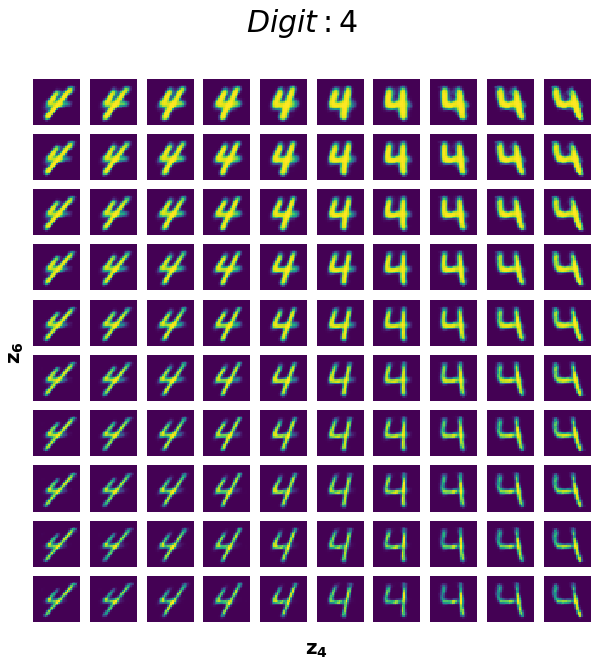

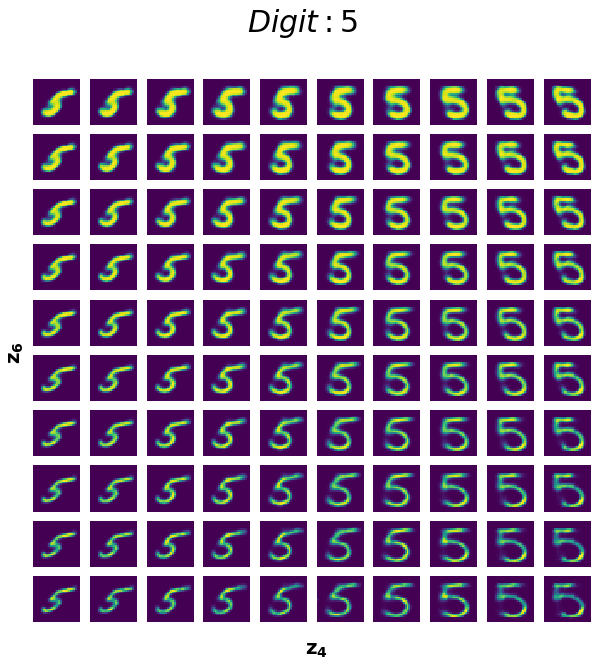

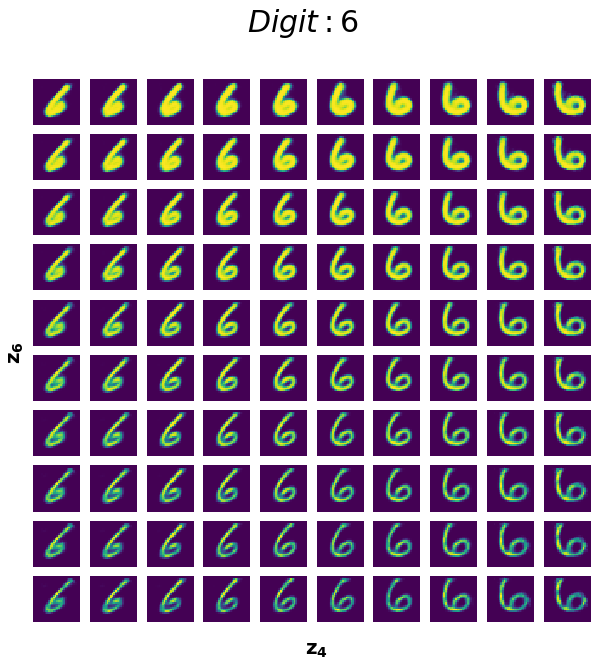

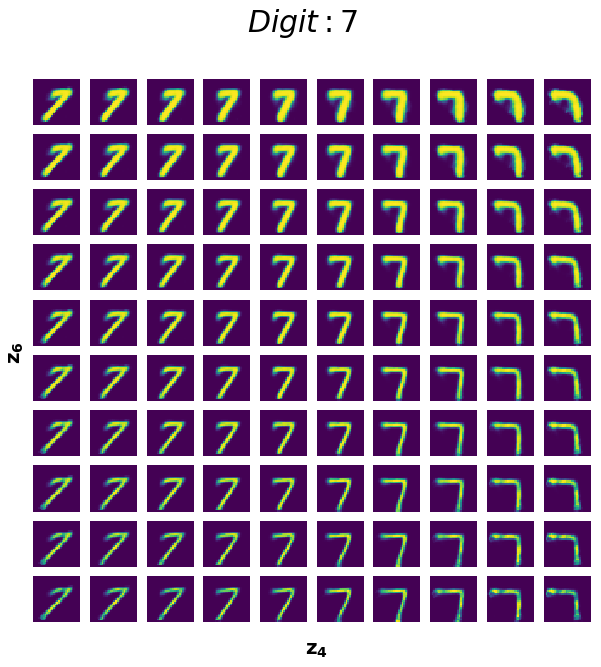

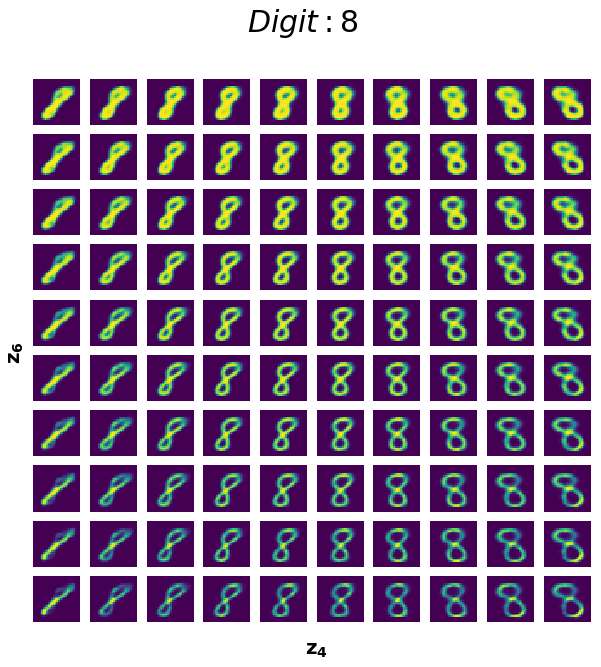

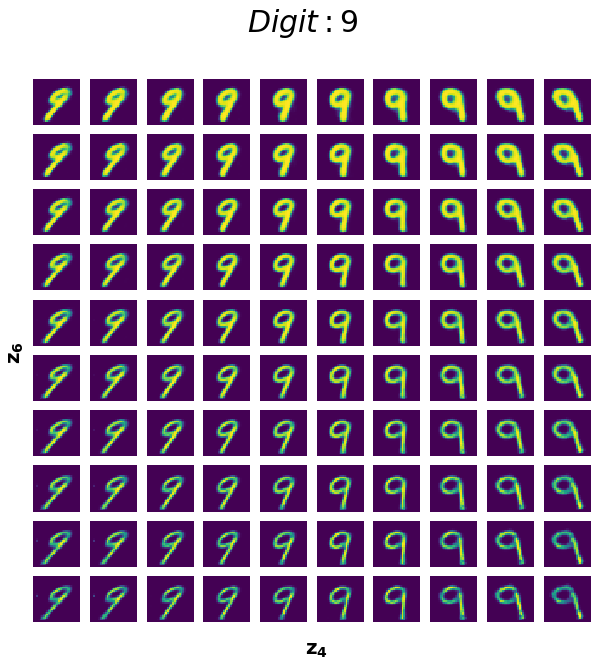

In [19]:
z_index1 = 6
z_index2 = 4
for digit in range(NUM_DIGITS):
    zi_vs_zj(z_index1, z_index2, zmin=-3, zmax=3, num_z=10, digit=digit)
    plt.show()

## Track terms Vs iters

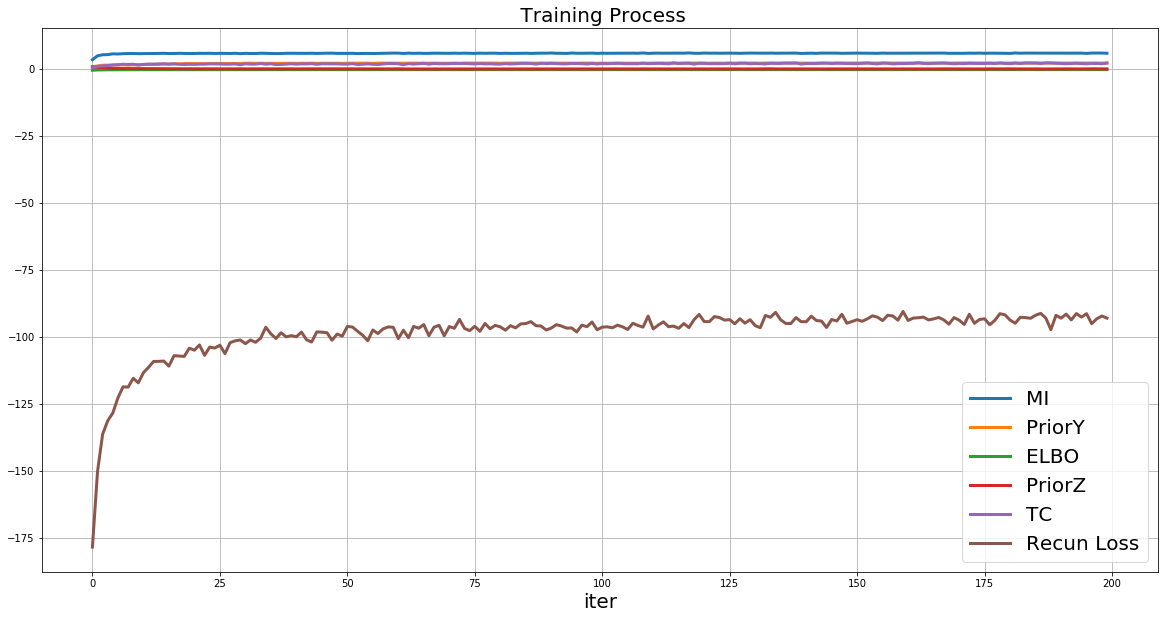

In [13]:
fig = plt.figure(figsize=(20,10))
iters = np.arange(NUM_EPOCHS)
for label in train_elbo_dict:
    plt.plot(iters, train_elbo_dict[label], label=label, linewidth=3)
plt.legend(prop={'size': 20})
plt.xlabel("iter", fontsize=20)
plt.title(" Training Process", fontsize=20)
plt.grid(True)
plt.show()

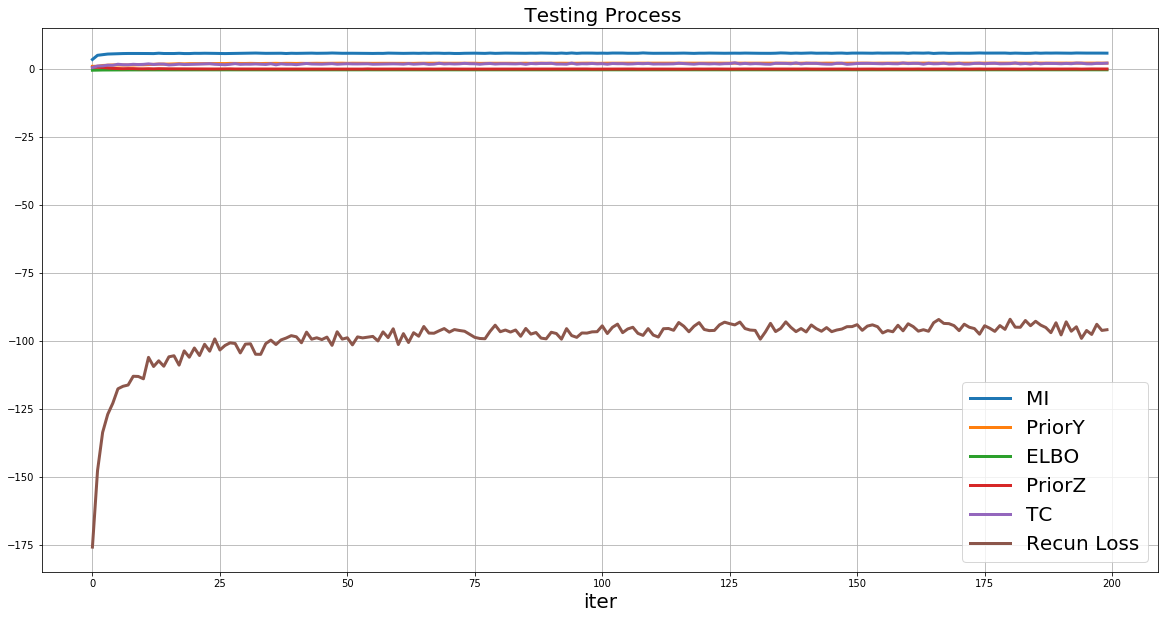

In [14]:
fig = plt.figure(figsize=(20,10))
iters = np.arange(NUM_EPOCHS)
for label in test_elbo_dict:
    plt.plot(iters, test_elbo_dict[label], label=label, linewidth=3)
plt.legend(prop={'size': 20})
plt.xlabel("iter", fontsize=20)
plt.title(" Testing Process", fontsize=20)
plt.grid(True)
plt.show()